<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


NameError: name 'temps' is not defined

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


NameError: name 'df_test' is not defined

Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

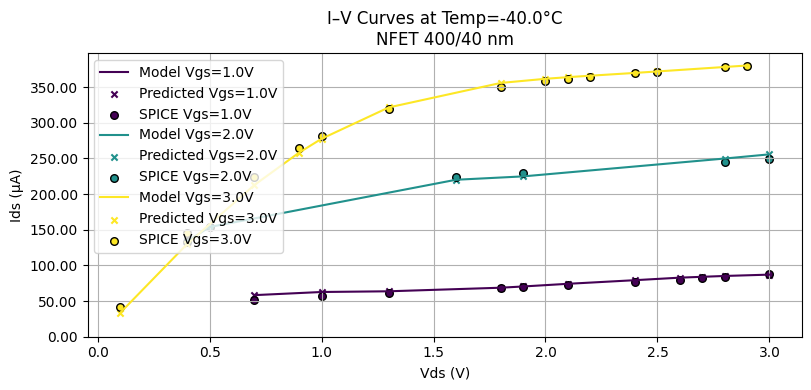

<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

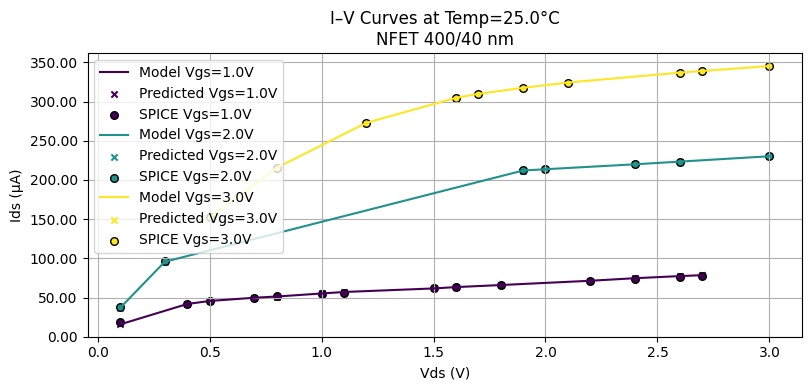

<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-6-cb7eeabc54eb>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

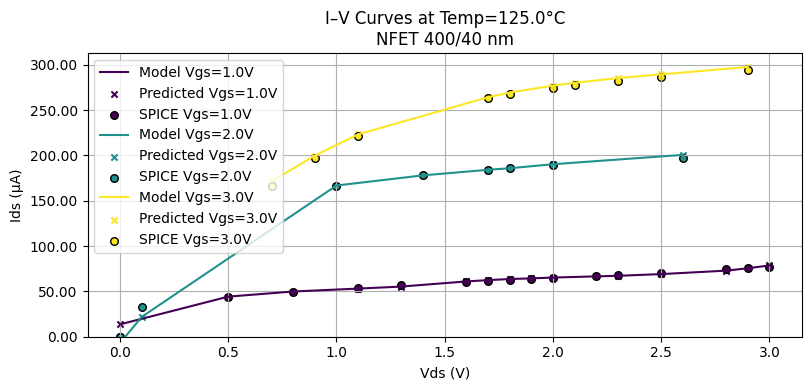

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

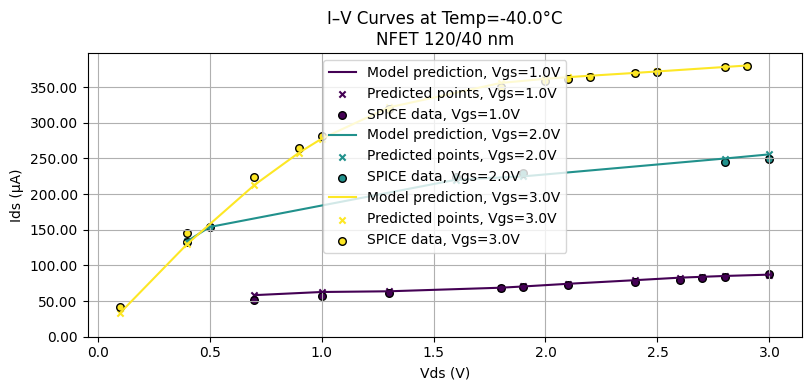

<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

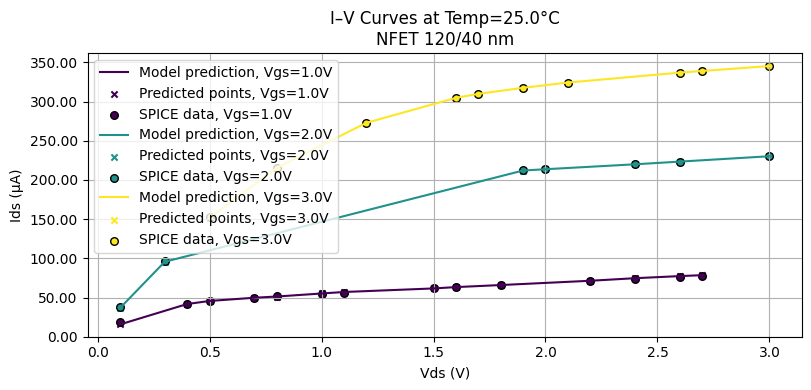

<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-9-d886115de4f2>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

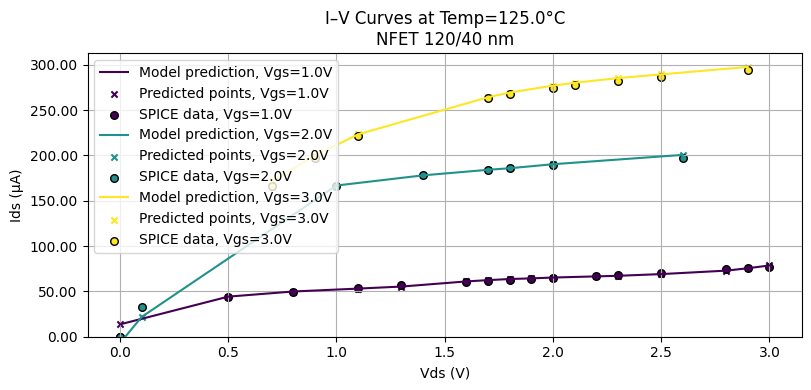

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 120/40 nm')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

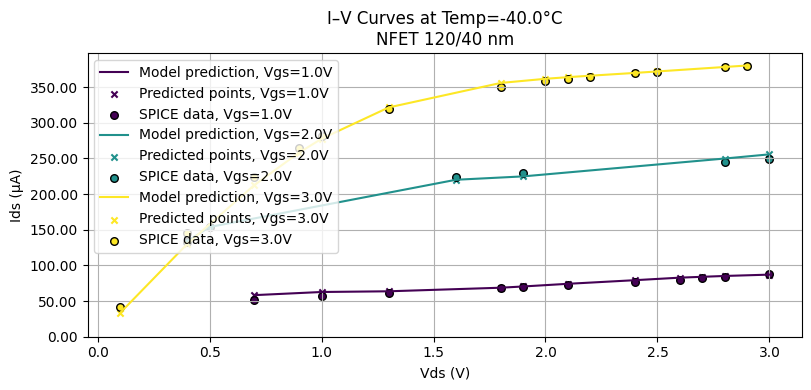

<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

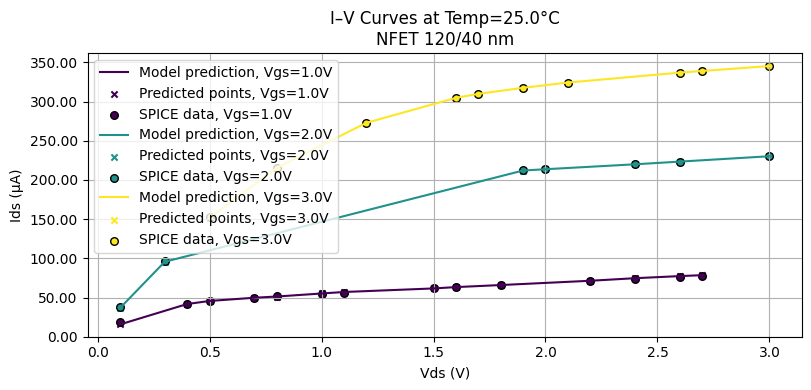

<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-11-89bcf34ed07d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

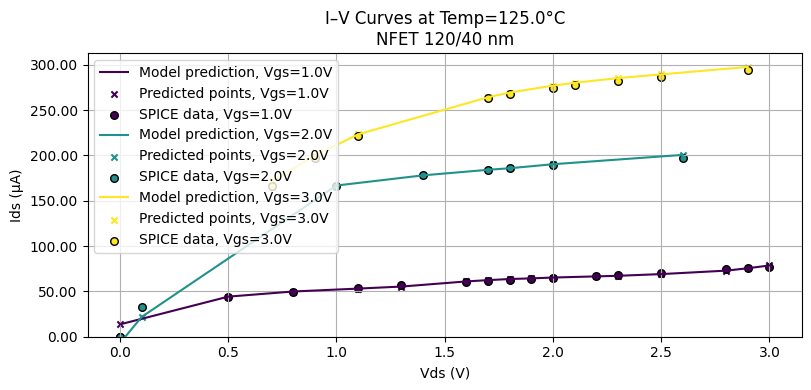

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_120_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 120/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

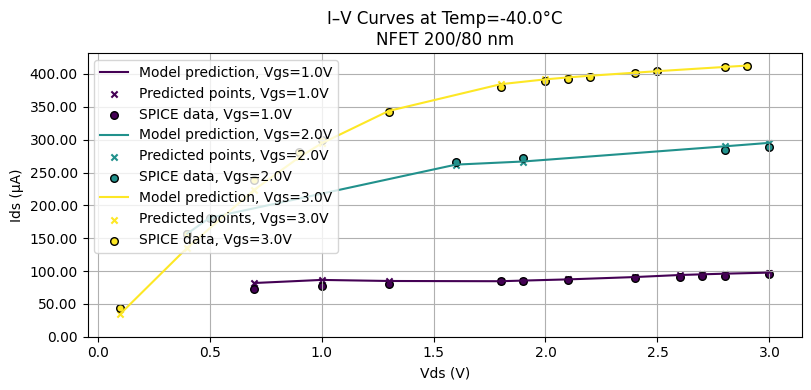

<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

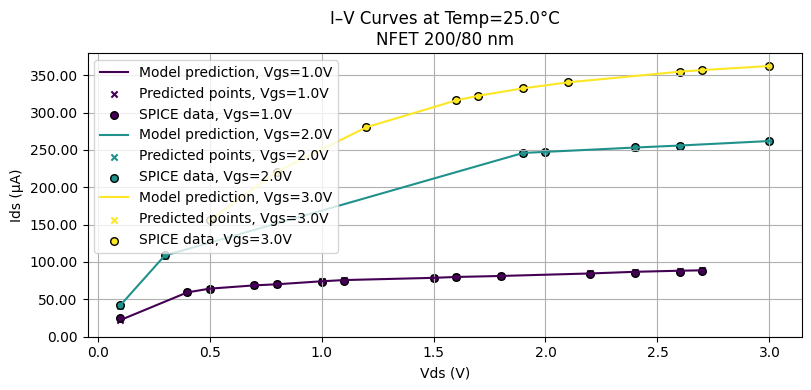

<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-14-804e500b93c1>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

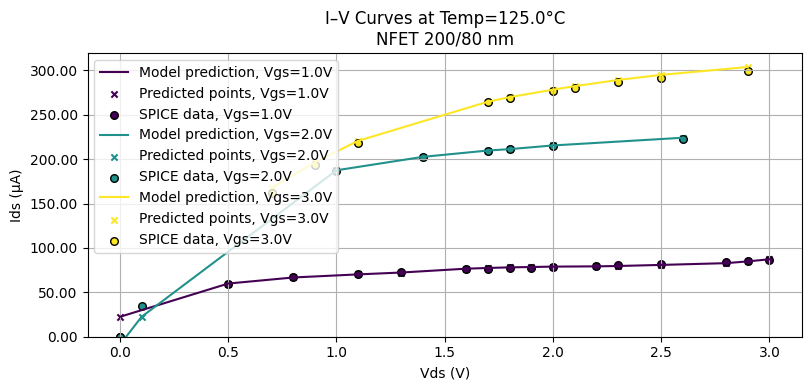

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_200_80.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 200/80 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6


<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

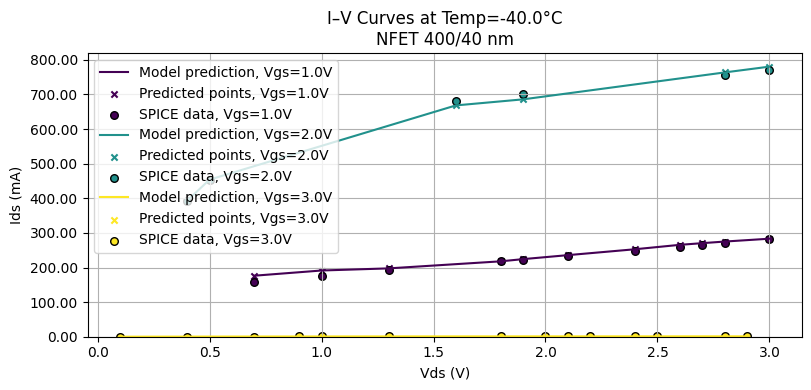

<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

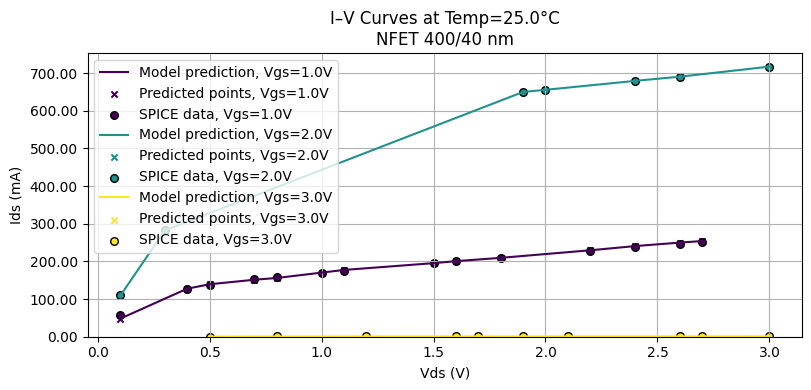

<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-15-a474f160d718>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

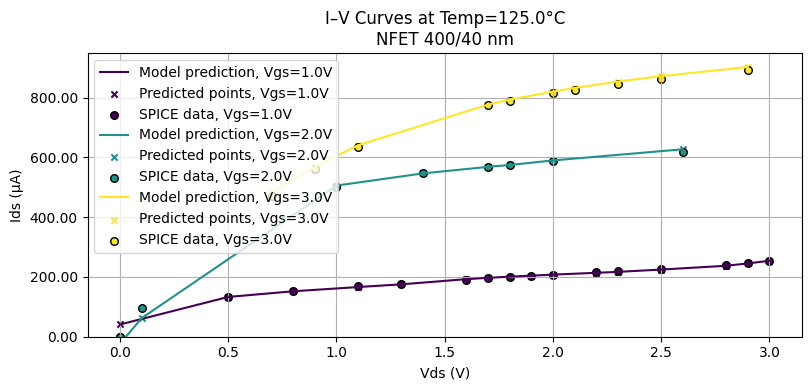

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_400_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6


<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

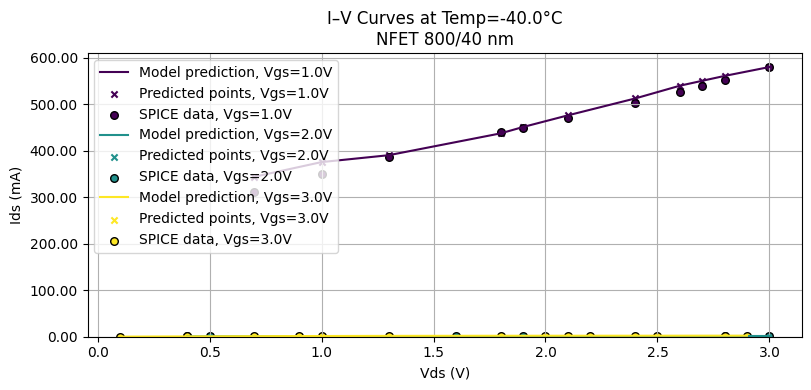

<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

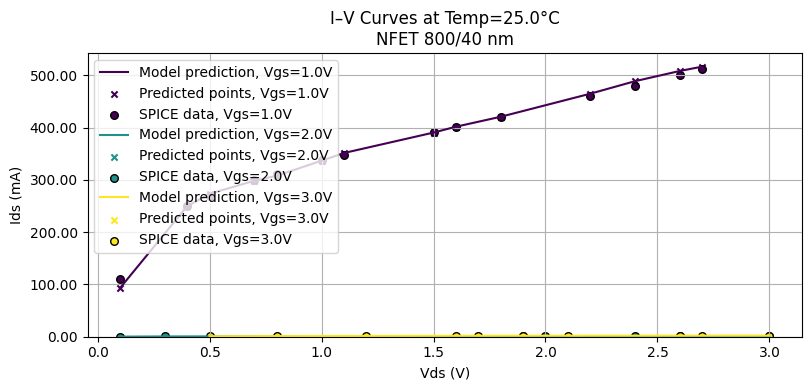

<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-16-bfa93966b12d>:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

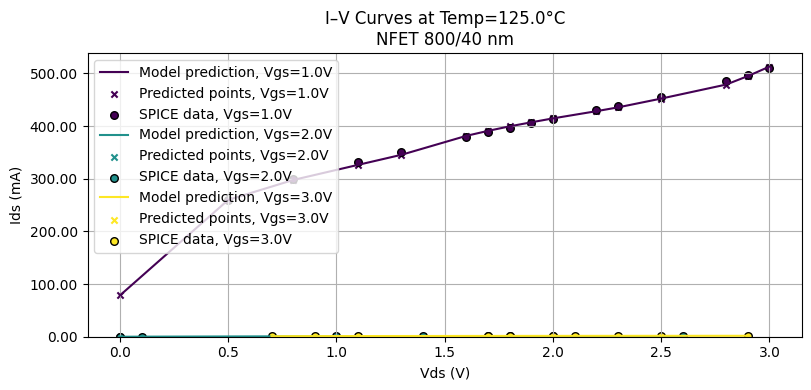

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6
Active Learning Iteration 2/6
Active Learning Iteration 3/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

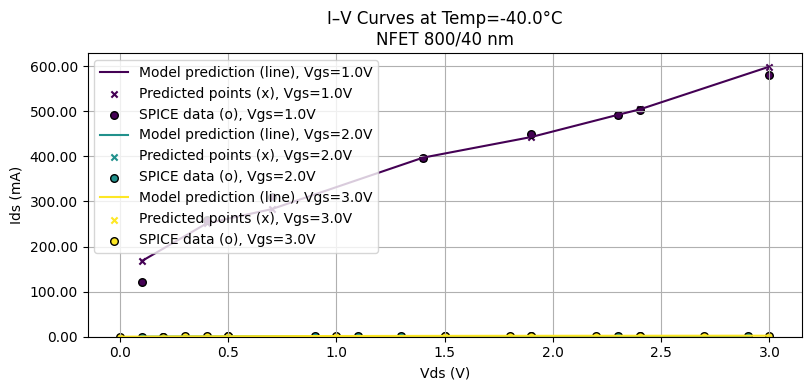

<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

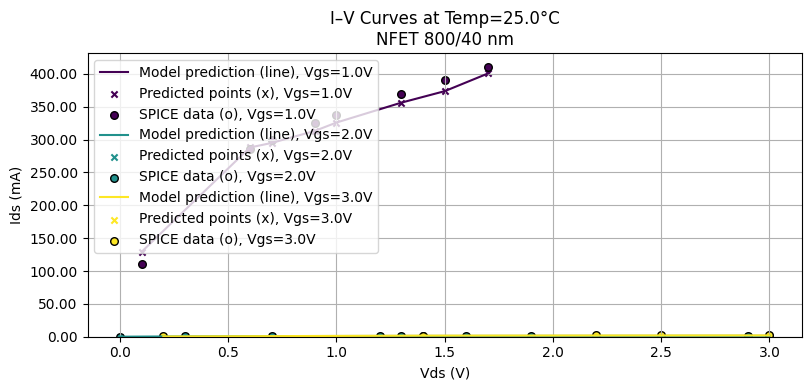

<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-17-78f323e4254b>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

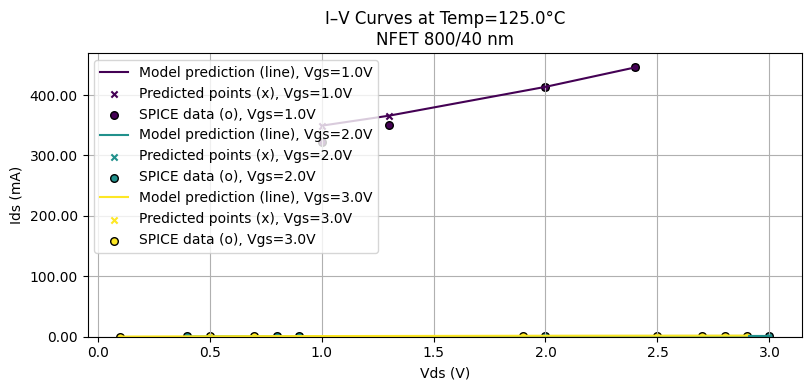

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']
from sklearn.utils import shuffle

df = shuffle(df, random_state=42)

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    vgs_focus = (
        np.exp(-((X_pool[:, 0] - 2.0) ** 2) / (2 * 0.3 ** 2)) +
        np.exp(-((X_pool[:, 0] - 3.0) ** 2) / (2 * 0.3 ** 2))
    )
    return 0.5 * ei + 0.2 * norm_dist + 0.2 * temp_focus + 0.1 * vgs_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction (line), Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points (x), Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data (o), Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Active Learning Iteration 1/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6
Active Learning Iteration 5/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-18-7

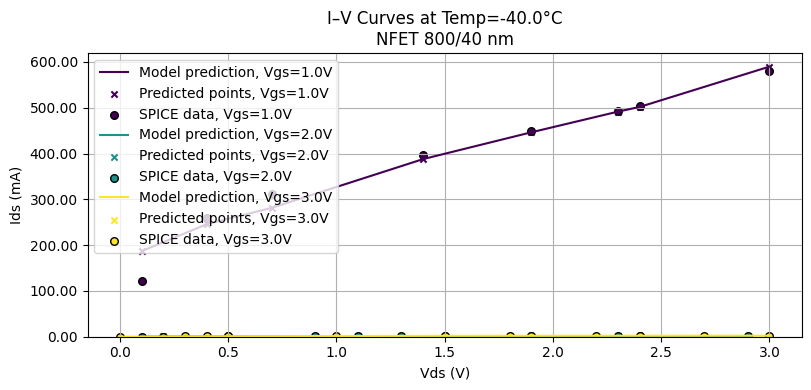

<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

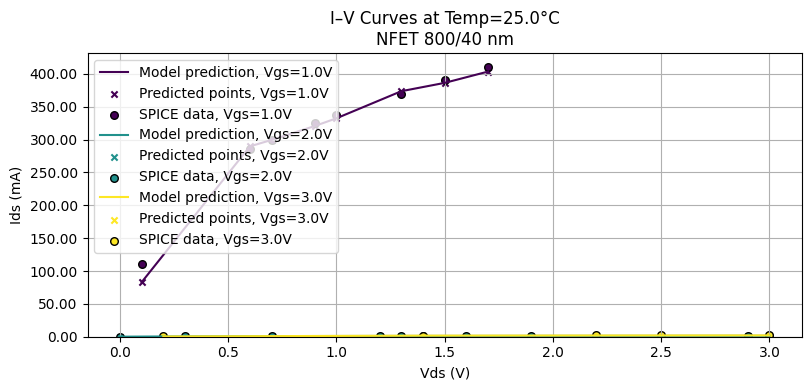

<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-18-76a96fe51687>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

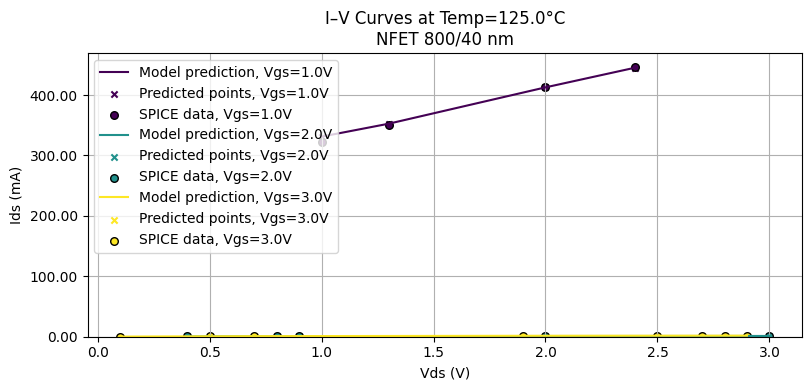

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']
from sklearn.utils import shuffle

df = shuffle(df, random_state=42)

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=200, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    vgs_focus = (
        np.exp(-((X_pool[:, 0] - 2.0) ** 2) / (2 * 0.3 ** 2)) +
        np.exp(-((X_pool[:, 0] - 3.0) ** 2) / (2 * 0.3 ** 2))
    )
    return 0.5 * ei + 0.2 * norm_dist + 0.2 * temp_focus + 0.1 * vgs_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


In [19]:
print("Training Vgs:", np.unique(X_train[:, 0], return_counts=True))


Training Vgs: (array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.2, 1.4, 1.6,
       1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]), array([11, 12, 11,  7, 15, 13, 11,  8,  5, 14, 15,  8, 18, 21, 31, 23, 17,
       21, 22, 37]))


Active Learning Iteration 1/6
Active Learning Iteration 2/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['V

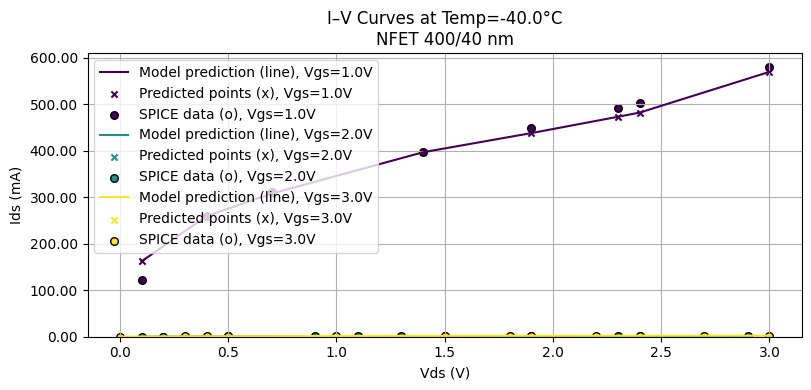

<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

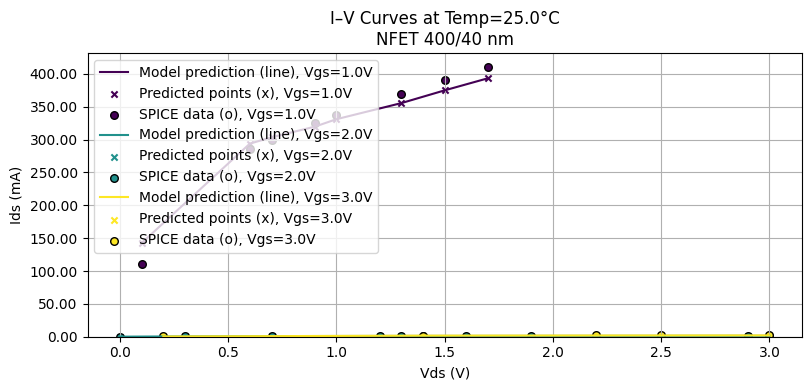

<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-21-07b470c9fb77>:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

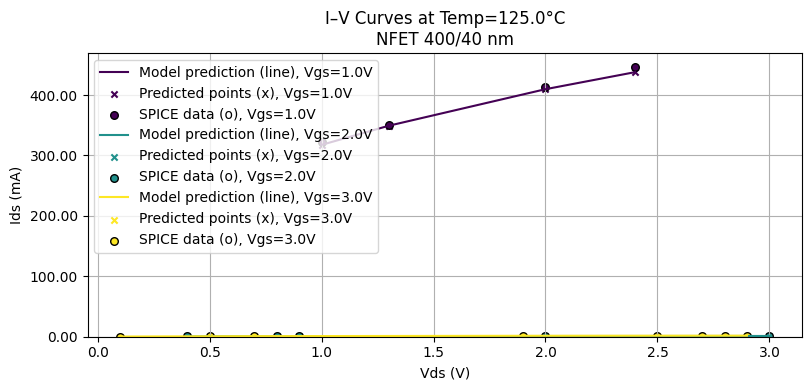

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']
from sklearn.utils import shuffle

df = shuffle(df, random_state=42)

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage

df['Veff'] = df['Vgs'] - Vth
# Add inverse slope feature



# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)

# Ensure Vgs = 2.0 and 3.0 are included
vgs_2_3_mask = (X_pool[:, 0] == 2.0) | (X_pool[:, 0] == 3.0)
vgs_2_3_indices = np.where(vgs_2_3_mask)[0]
selected_vgs_indices = np.random.choice(vgs_2_3_indices, size=min(20, len(vgs_2_3_indices)), replace=False)

# Randomly sample the rest to reach 200
remaining_indices = np.setdiff1d(np.arange(len(X_pool)), selected_vgs_indices)
other_indices = np.random.choice(remaining_indices, size=200 - len(selected_vgs_indices), replace=False)

# Combine
initial_indices = np.concatenate((selected_vgs_indices, other_indices))
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    vgs_focus = (
        np.exp(-((X_pool[:, 0] - 2.0) ** 2) / (2 * 0.3 ** 2)) +
        np.exp(-((X_pool[:, 0] - 3.0) ** 2) / (2 * 0.3 ** 2))
    )
    return 0.5 * ei + 0.2 * norm_dist + 0.2 * temp_focus + 0.1 * vgs_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))  # Updated after log-scaling

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    for i, vgs in enumerate(vgs_values):
        subset = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))]
        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction (line), Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points (x), Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data (o), Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 400/40 nm')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()


Unique Vgs values in dataset: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.2), np.float64(1.4), np.float64(1.6), np.float64(1.8), np.float64(2.0), np.float64(2.2), np.float64(2.4), np.float64(2.6), np.float64(2.8), np.float64(3.0)]
Unique Temperature values in dataset: [np.int64(-40), np.int64(25), np.int64(125)]
Training pool size: 1302, Evaluation set size: 558
Active Learning Iteration 1/6
Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6
Active Learning Iteration 5/6
Active Learning Iteration 6/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-22-35e658feed22>

Data points in test set for Vgs=1.0V at Temp=-40.0°C: 9
Data points in test set for Vgs=1.0V at Temp=25.0°C: 10
Data points in test set for Vgs=1.0V at Temp=125.0°C: 9
Data points in test set for Vgs=2.0V at Temp=-40.0°C: 10
Data points in test set for Vgs=2.0V at Temp=25.0°C: 9
Data points in test set for Vgs=2.0V at Temp=125.0°C: 9
Data points in test set for Vgs=3.0V at Temp=-40.0°C: 9
Data points in test set for Vgs=3.0V at Temp=25.0°C: 10
Data points in test set for Vgs=3.0V at Temp=125.0°C: 10


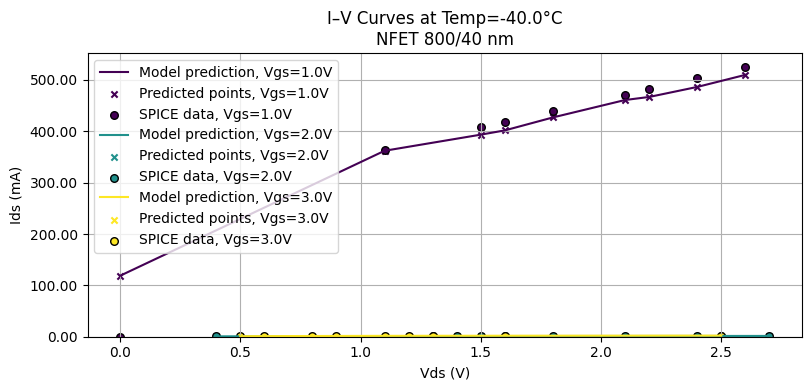

<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

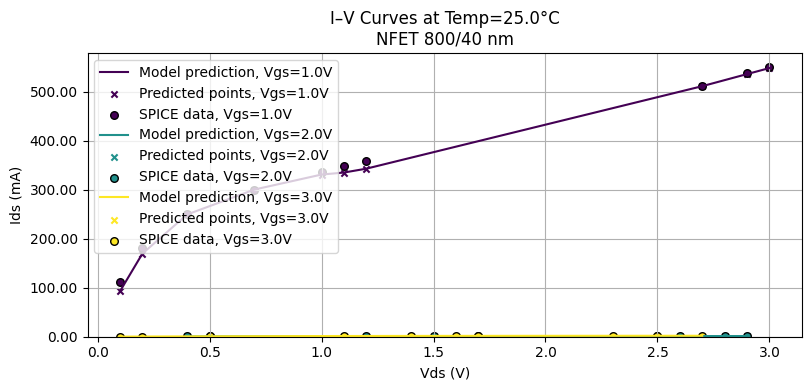

<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-22-35e658feed22>:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

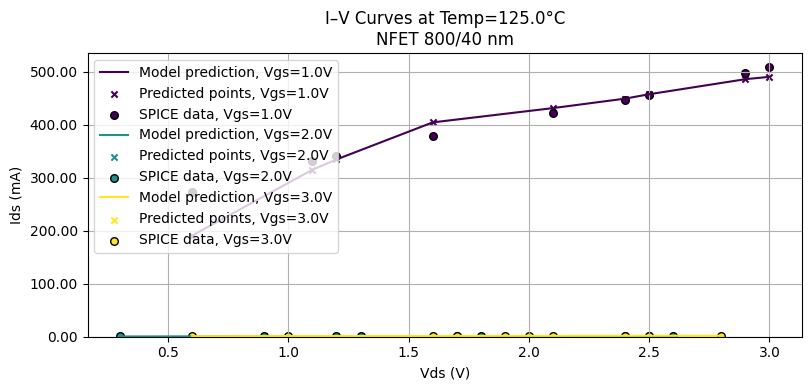

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Print unique Vgs values to verify data
print("Unique Vgs values in dataset:", sorted(df['Vgs'].unique()))
print("Unique Temperature values in dataset:", sorted(df['Temp'].unique()))

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage
df['Veff'] = df['Vgs'] - Vth

# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# IMPORTANT CHANGE: Stratified split to ensure representation of all Vgs values
# First, create a stratification column that combines Temp and Vgs
df['strat_col'] = df['Temp'].astype(str) + '_' + df['Vgs'].astype(str)
strat_labels = df['strat_col'].values

# Now use stratified split to maintain the distribution
X_pool, X_eval, y_pool, y_eval, strat_pool, strat_eval = train_test_split(
    X_full, y_full, strat_labels, test_size=0.3, random_state=42, stratify=strat_labels
)

print(f"Training pool size: {len(X_pool)}, Evaluation set size: {len(X_eval)}")

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

# IMPORTANT CHANGE: Create a DataFrame from evaluation data
df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()

# Check if we have the expected data points in the test set
for vgs in vgs_values:
    for temp in sorted(df_test['Temp'].unique()):
        count = df_test[(np.isclose(df_test['Temp'], temp)) & (np.isclose(df_test['Vgs'], vgs))].shape[0]
        print(f"Data points in test set for Vgs={vgs}V at Temp={temp}°C: {count}")

# Increase tolerance for floating-point comparisons
TOLERANCE = 1e-3

# Plot IV curves for different temperatures
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))

    for i, vgs in enumerate(vgs_values):
        # Use more tolerant comparison for floating point
        subset = df_test[(np.abs(df_test['Temp'] - temp) < TOLERANCE) &
                         (np.abs(df_test['Vgs'] - vgs) < TOLERANCE)]

        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            # Create dummy plot with label to maintain consistency
            plt.plot([], [], label=f'Model prediction, Vgs={vgs}V', color=colors[i])
            continue

        # Recalculate Veff in case it wasn't properly passed to the test set
        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        max_current = max(np.max(y_true_sorted), np.max(y_pred_sorted))
        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        plt.plot(vds_sorted, y_pred_sorted * scale_factor, label=f'Model prediction, Vgs={vgs}V', color=colors[i])
        plt.scatter(vds_sorted, y_pred_sorted * scale_factor, color=colors[i], s=20, marker='x', label=f'Predicted points, Vgs={vgs}V')
        plt.scatter(vds_sorted, y_true_sorted * scale_factor, marker='o', s=30, label=f'SPICE data, Vgs={vgs}V', color=colors[i], edgecolor='black')

    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)

    # IMPORTANT CHANGE: Create a simplified legend that won't be duplicated
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left')

    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)
    plt.show()

Unique Vgs values in dataset: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.2), np.float64(1.4), np.float64(1.6), np.float64(1.8), np.float64(2.0), np.float64(2.2), np.float64(2.4), np.float64(2.6), np.float64(2.8), np.float64(3.0)]
Unique Temperature values in dataset: [np.int64(-40), np.int64(25), np.int64(125)]
Active Learning Iteration 1/6
Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6
Data points in test set for Vgs=1.0V at Temp=-40.0°C: 11
Data points in test set for Vgs=1.0V at Temp=25.0°C: 14
Data points in test set for Vgs=1.0V at Temp=125.0°C: 16
Data points in test set for Vgs=2.0V at Temp=-40.0°C: 6
Data points in test set for Vgs=2.0V at Temp=25.0°C: 7
Data points in test set for Vgs=2.0V at Temp=125.0°C: 8
Data points in test set for Vgs=3.0V at Temp=-40.0°C: 14
Data points in test set for Vgs=3.0V at Temp=25.0°C: 10
Data points in test set for Vgs=3.0V at Temp=125.0°C: 10


<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

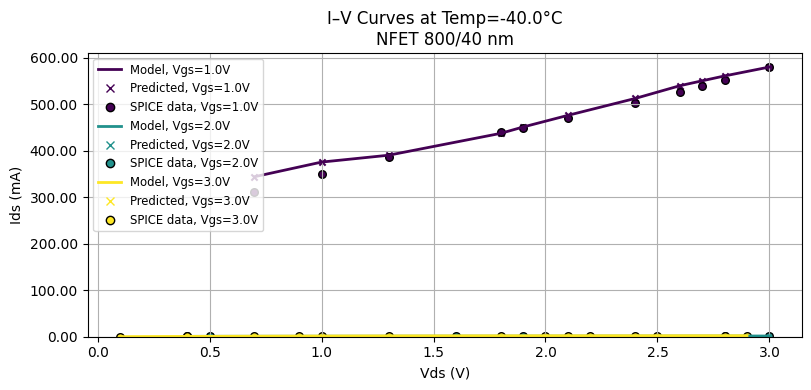

<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

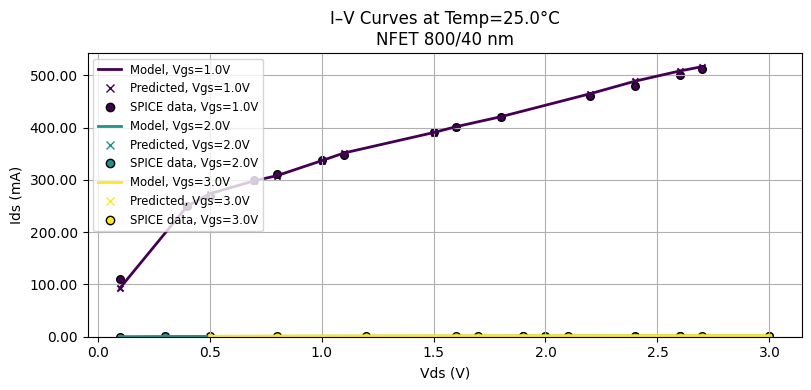

<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

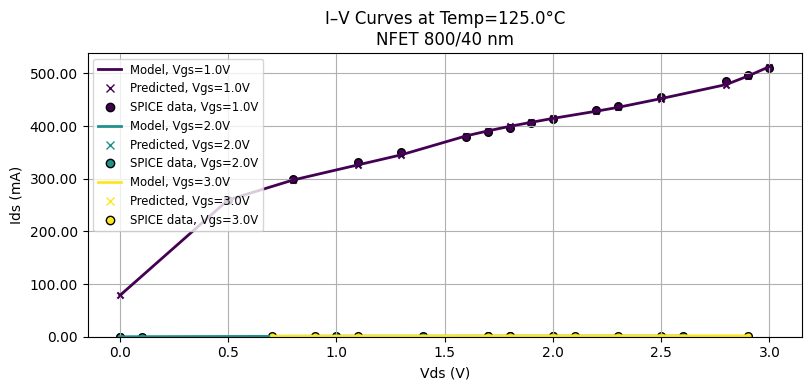

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Print unique Vgs values to verify data
print("Unique Vgs values in dataset:", sorted(df['Vgs'].unique()))
print("Unique Temperature values in dataset:", sorted(df['Temp'].unique()))

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage
df['Veff'] = df['Vgs'] - Vth

# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets with a fixed random state
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

# Create DataFrame from evaluation data
df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()

# Print verification of what we have in the test set
for vgs in vgs_values:
    for temp in sorted(df_test['Temp'].unique()):
        count = df_test[(np.isclose(df_test['Temp'], temp, rtol=1e-3)) &
                         (np.isclose(df_test['Vgs'], vgs, rtol=1e-3))].shape[0]
        print(f"Data points in test set for Vgs={vgs}V at Temp={temp}°C: {count}")

# Use an increased tolerance for floating point comparisons
# This is a key fix to ensure we match data points correctly
TOLERANCE = 1e-3

# Plot IV curves for different temperatures
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    legend_entries = []

    for i, vgs in enumerate(vgs_values):
        # Use more tolerant comparison for floating point values
        subset = df_test[(np.abs(df_test['Temp'] - temp) < TOLERANCE) &
                         (np.abs(df_test['Vgs'] - vgs) < TOLERANCE)]

        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        # Make sure Veff is updated with the correct threshold voltage
        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        # Generate predictions
        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        # Check for NaN or very small values in predictions
        if np.isnan(y_pred).any() or np.max(np.abs(y_pred)) < 1e-20:
            print(f"WARNING: NaN or very small predictions for Vgs={vgs}V at Temp={temp}°C")
            print(f"Min y_pred: {np.min(y_pred)}, Max y_pred: {np.max(y_pred)}")
            # Replace NaN with small values if needed
            y_pred = np.nan_to_num(y_pred, nan=1e-12)

        # Sort by Vds for smooth curves
        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        # Ensure we have valid values to plot
        if np.isnan(y_true_sorted).any() or np.isnan(y_pred_sorted).any():
            print(f"WARNING: NaN values after sorting for Vgs={vgs}V")
            y_true_sorted = np.nan_to_num(y_true_sorted, nan=1e-12)
            y_pred_sorted = np.nan_to_num(y_pred_sorted, nan=1e-12)

        # Calculate scale factor - this uses the maximum of both true and predicted values
        max_current = max(np.max(np.abs(y_true_sorted)), np.max(np.abs(y_pred_sorted)))
        if max_current < 1e-12:  # If values are extremely small, use a default
            print(f"WARNING: Very small current values for Vgs={vgs}V at Temp={temp}°C")
            max_current = 1e-6  # Default to prevent division by zero

        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        # Plot model prediction
        line, = plt.plot(vds_sorted, y_pred_sorted * scale_factor,
                     color=colors[i], linewidth=2)

        # Plot predicted points
        scatter1 = plt.scatter(vds_sorted, y_pred_sorted * scale_factor,
                          color=colors[i], s=20, marker='x')

        # Plot SPICE data
        scatter2 = plt.scatter(vds_sorted, y_true_sorted * scale_factor,
                          marker='o', s=30, color=colors[i], edgecolor='black')

        # Add to legend with clear labels
        legend_entries.append((line, f'Model prediction, Vgs={vgs}V'))

    # Xlabel, ylabel, and title
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)

    # Create legend only once per temperature plot
    # This fixes the duplicated legend entries
    from matplotlib.lines import Line2D
    legend_elements = []
    for i, vgs in enumerate(vgs_values):
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=2,
                              label=f'Model, Vgs={vgs}V'))
        legend_elements.append(Line2D([0], [0], marker='x', color=colors[i],
                              label=f'Predicted, Vgs={vgs}V', markersize=6, linestyle='None'))
        legend_elements.append(Line2D([0], [0], marker='o', color=colors[i],
                              label=f'SPICE data, Vgs={vgs}V', markersize=6,
                              linestyle='None', markeredgecolor='black'))

    plt.legend(handles=legend_elements, loc='upper left', fontsize='small')

    # Layout and formatting
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)  # Start y-axis from 0
    plt.show()

Unique Vgs values in dataset: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8), np.float64(0.9), np.float64(1.0), np.float64(1.2), np.float64(1.4), np.float64(1.6), np.float64(1.8), np.float64(2.0), np.float64(2.2), np.float64(2.4), np.float64(2.6), np.float64(2.8), np.float64(3.0)]
Unique Temperature values in dataset: [np.int64(-40), np.int64(25), np.int64(125)]
Active Learning Iteration 1/6
Active Learning Iteration 2/6
Active Learning Iteration 3/6
Active Learning Iteration 4/6


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Active Learning Iteration 5/6
Active Learning Iteration 6/6
Data points in test set for Vgs=1.0V at Temp=-40.0°C: 11
Data points in test set for Vgs=1.0V at Temp=25.0°C: 14
Data points in test set for Vgs=1.0V at Temp=125.0°C: 16
Data points in test set for Vgs=2.0V at Temp=-40.0°C: 6
Data points in test set for Vgs=2.0V at Temp=25.0°C: 7
Data points in test set for Vgs=2.0V at Temp=125.0°C: 8
Data points in test set for Vgs=3.0V at Temp=-40.0°C: 14
Data points in test set for Vgs=3.0V at Temp=25.0°C: 10
Data points in test set for Vgs=3.0V at Temp=125.0°C: 10


<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

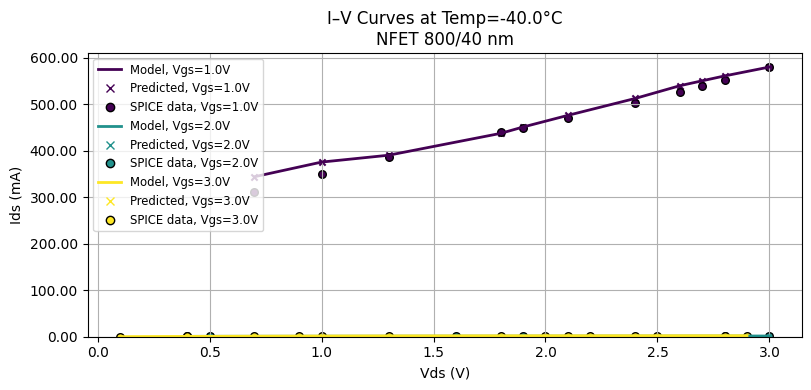

<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

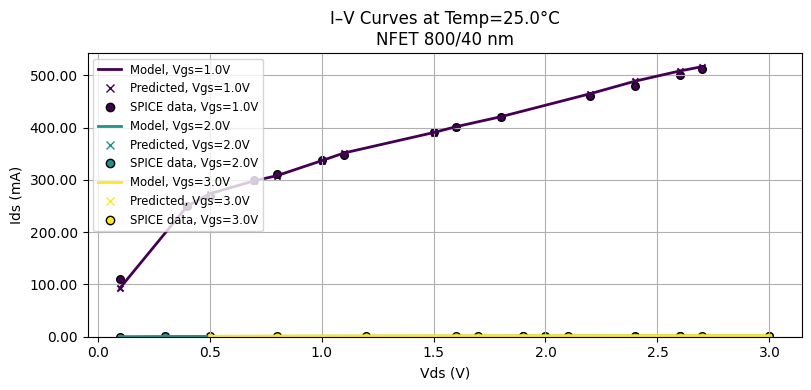

<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Veff'] = subset['Vgs'] - Vth
<ipython-input-23-12cfb7b4bc6b>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

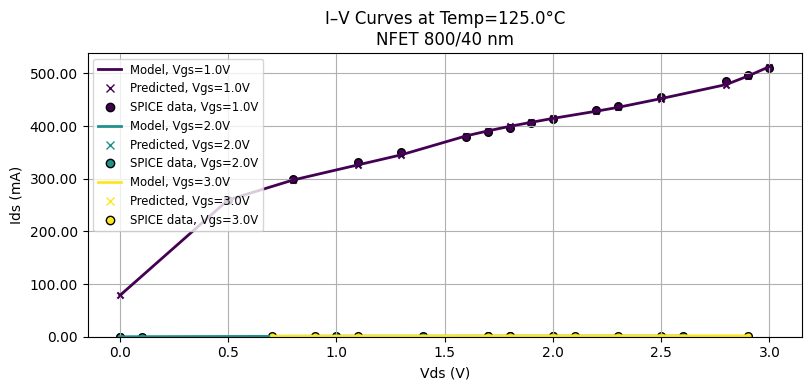

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_squared_error, r2_score
from scipy.special import erf

# Load dataset
df = pd.read_csv('nfet_800_40.CSV')
df = df[['temp', 'V_gs', 'V_ds', 'I_ds']].dropna()
df.columns = ['Temp', 'Vgs', 'Vds', 'Ids']

# Print unique Vgs values to verify data
print("Unique Vgs values in dataset:", sorted(df['Vgs'].unique()))
print("Unique Temperature values in dataset:", sorted(df['Temp'].unique()))

# Add effective gate voltage feature
Vth = 0.6  # Assumed threshold voltage
df['Veff'] = df['Vgs'] - Vth

# Create input and output arrays
X_full = df[['Vgs', 'Vds', 'Temp', 'Veff']].values
y_full = df['Ids'].values.reshape(-1, 1)

# Split into disjoint training and evaluation sets with a fixed random state
X_pool, X_eval, y_pool, y_eval = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Initialize with a small training subset from X_pool
np.random.seed(42)
initial_indices = np.random.choice(len(X_pool), size=100, replace=False)
X_train = X_pool[initial_indices]
y_train = y_pool[initial_indices]

# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Define models
def create_nn_model(X, y):
    param_grid = {
        'hidden_layer_sizes': [(200, 150, 100), (150, 100, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [10000]
    }
    model = MLPRegressor(random_state=42, early_stopping=True)
    grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    Xs = scaler_X.fit_transform(X)
    ys = scaler_y.fit_transform(y)
    grid.fit(Xs, ys.ravel())
    return grid.best_estimator_

def create_gp_model():
    kernel = ConstantKernel(1.0) * (RBF() + RationalQuadratic()) + WhiteKernel(noise_level=1e-5)
    return GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True, n_restarts_optimizer=5)

def acquisition_function(mean, std, best_y, X_pool, X_train, xi=0.01):
    improvement = mean - best_y - xi
    z = improvement / (std + 1e-9)
    ei = improvement * (0.5 * (1 + erf(z / np.sqrt(2))))
    ei[std == 0] = 0.0
    distances = np.min(np.linalg.norm(X_pool[:, None] - X_train[None, :], axis=2), axis=1)
    norm_dist = distances / (np.max(distances) + 1e-10)
    temp_focus = np.exp(-((X_pool[:, 2] - 25.0) ** 2) / (2 * 50 ** 2))
    return 0.6 * ei + 0.2 * norm_dist + 0.2 * temp_focus

# Active Learning Loop
for i in range(6):
    print(f"Active Learning Iteration {i+1}/6")
    X_scaled = scaler_X.fit_transform(X_train)
    y_scaled = scaler_y.fit_transform(y_train)

    nn_model = create_nn_model(X_train, y_train)
    nn_model.fit(X_scaled, y_scaled.ravel())

    X_pool_scaled = scaler_X.transform(X_pool)
    y_nn_scaled = nn_model.predict(X_pool_scaled).reshape(-1, 1)
    y_nn = scaler_y.inverse_transform(y_nn_scaled)

    y_train_pred_scaled = nn_model.predict(X_scaled).reshape(-1, 1)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
    residuals = y_train - y_train_pred

    gp_model = create_gp_model()
    gp_model.fit(X_train, residuals.ravel())

    gp_corr, gp_std = gp_model.predict(X_pool, return_std=True)
    final_pred = y_nn + gp_corr.reshape(-1, 1)

    best_pred = np.max(y_nn)
    acq_values = acquisition_function(y_nn.ravel(), gp_std, best_pred, X_pool, X_train)
    new_indices = np.argsort(acq_values)[-20:]
    X_new = X_pool[new_indices]
    y_new = y_pool[new_indices]
    X_train = np.vstack((X_train, X_new))
    y_train = np.vstack((y_train, y_new))

# Evaluate on X_eval
import matplotlib.cm as cm
vgs_values = [1.0, 2.0, 3.0]
colors = cm.viridis(np.linspace(0, 1, len(vgs_values)))

# Create DataFrame from evaluation data
df_test = pd.DataFrame(X_eval, columns=['Vgs', 'Vds', 'Temp', 'Veff'])
df_test['Ids'] = y_eval.flatten()

# Print verification of what we have in the test set
for vgs in vgs_values:
    for temp in sorted(df_test['Temp'].unique()):
        count = df_test[(np.isclose(df_test['Temp'], temp, rtol=1e-3)) &
                         (np.isclose(df_test['Vgs'], vgs, rtol=1e-3))].shape[0]
        print(f"Data points in test set for Vgs={vgs}V at Temp={temp}°C: {count}")

# Use an increased tolerance for floating point comparisons
# This is a key fix to ensure we match data points correctly
TOLERANCE = 1e-3

# Plot IV curves for different temperatures
temps = sorted(df_test['Temp'].unique())
for temp in temps:
    plt.figure(figsize=(8, 4))
    legend_entries = []

    for i, vgs in enumerate(vgs_values):
        # Use more tolerant comparison for floating point values
        subset = df_test[(np.abs(df_test['Temp'] - temp) < TOLERANCE) &
                         (np.abs(df_test['Vgs'] - vgs) < TOLERANCE)]

        if subset.empty:
            print(f"No data for Vgs={vgs}V at Temp={temp}°C in the test set.")
            continue

        # Make sure Veff is updated with the correct threshold voltage
        subset['Veff'] = subset['Vgs'] - Vth
        X_eval_subset = subset[['Vgs', 'Vds', 'Temp', 'Veff']].values
        y_true = subset['Ids'].values

        # Generate predictions
        X_eval_scaled = scaler_X.transform(X_eval_subset)
        y_nn_scaled = nn_model.predict(X_eval_scaled).reshape(-1, 1)
        y_nn = scaler_y.inverse_transform(y_nn_scaled)
        gp_corr, _ = gp_model.predict(X_eval_subset, return_std=True)
        y_pred = y_nn + gp_corr.reshape(-1, 1)

        # Check for NaN or very small values in predictions
        if np.isnan(y_pred).any() or np.max(np.abs(y_pred)) < 1e-20:
            print(f"WARNING: NaN or very small predictions for Vgs={vgs}V at Temp={temp}°C")
            print(f"Min y_pred: {np.min(y_pred)}, Max y_pred: {np.max(y_pred)}")
            # Replace NaN with small values if needed
            y_pred = np.nan_to_num(y_pred, nan=1e-12)

        # Sort by Vds for smooth curves
        sorted_idx = np.argsort(subset['Vds'].values)
        vds_sorted = subset['Vds'].values[sorted_idx]
        y_true_sorted = y_true[sorted_idx]
        y_pred_sorted = y_pred.flatten()[sorted_idx]

        # Ensure we have valid values to plot
        if np.isnan(y_true_sorted).any() or np.isnan(y_pred_sorted).any():
            print(f"WARNING: NaN values after sorting for Vgs={vgs}V")
            y_true_sorted = np.nan_to_num(y_true_sorted, nan=1e-12)
            y_pred_sorted = np.nan_to_num(y_pred_sorted, nan=1e-12)

        # Calculate scale factor - this uses the maximum of both true and predicted values
        max_current = max(np.max(np.abs(y_true_sorted)), np.max(np.abs(y_pred_sorted)))
        if max_current < 1e-12:  # If values are extremely small, use a default
            print(f"WARNING: Very small current values for Vgs={vgs}V at Temp={temp}°C")
            max_current = 1e-6  # Default to prevent division by zero

        scale_factor = 1e3 if max_current >= 1e-3 else 1e6
        unit_label = 'mA' if scale_factor == 1e3 else 'μA'

        # Plot model prediction
        line, = plt.plot(vds_sorted, y_pred_sorted * scale_factor,
                     color=colors[i], linewidth=2)

        # Plot predicted points
        scatter1 = plt.scatter(vds_sorted, y_pred_sorted * scale_factor,
                          color=colors[i], s=20, marker='x')

        # Plot SPICE data
        scatter2 = plt.scatter(vds_sorted, y_true_sorted * scale_factor,
                          marker='o', s=30, color=colors[i], edgecolor='black')

        # Add to legend with clear labels
        legend_entries.append((line, f'Model prediction, Vgs={vgs}V'))

    # Xlabel, ylabel, and title
    plt.xlabel('Vds (V)')
    plt.ylabel(f'Ids ({unit_label})')
    plt.title(f'I–V Curves at Temp={temp}°C\nNFET 800/40 nm')
    plt.grid(True)

    # Create legend only once per temperature plot
    # This fixes the duplicated legend entries
    from matplotlib.lines import Line2D
    legend_elements = []
    for i, vgs in enumerate(vgs_values):
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=2,
                              label=f'Model, Vgs={vgs}V'))
        legend_elements.append(Line2D([0], [0], marker='x', color=colors[i],
                              label=f'Predicted, Vgs={vgs}V', markersize=6, linestyle='None'))
        legend_elements.append(Line2D([0], [0], marker='o', color=colors[i],
                              label=f'SPICE data, Vgs={vgs}V', markersize=6,
                              linestyle='None', markeredgecolor='black'))

    plt.legend(handles=legend_elements, loc='upper left', fontsize='small')

    # Layout and formatting
    plt.tight_layout()
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.ylim(bottom=0)  # Start y-axis from 0
    plt.show()